In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from compare_wandb import load_full_df, get_test_pdbs, load_run_dict

import wandb
api = wandb.Api()
entity = 'proteins'
project = 'iclr2021-rebuttal'

import boto3
import os
s3 = boto3.client("s3")
s3_bucket = "proteindata"

import torch

# load metatest pdbs
with open('metatest_fams.txt', 'r') as f:
    lines = f.readlines()
    metatest_pdbs = [l.strip() for l in lines]

from mogwai import models
from mogwai.utils.functional import apc
model_name = 'factored_attention'
fatt_model = models.get(model_name)
gremlin_model = models.get('gremlin')

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from scipy.stats import spearmanr
from scipy.stats import pearsonr

import pickle as pkl

import h5py

In [156]:
head_sweep_runs = {
    'fatt-metatest-head-sweep-512': 'bxnkt0uq',
    'fatt-metatest-head-256': 'xuofwjtc',
    'fatt-metatest-head-sweep-64-kqe7or39': 'kqe7or39',
    'fatt-metatest-head-sweep-128': '32emd6ri',
    'fatt-metatest-head-sweep-8-32': '8yi6a4w5',
}

dict_of_dfs = load_run_dict(head_sweep_runs)
fatt_df = pd.concat(list(dict_of_dfs.values()))

  0%|          | 0/2233 [00:00<?, ?it/s]

bxnkt0uq has 748 runs
xuofwjtc has 748 runs
kqe7or39 has 748 runs
32emd6ri has 748 runs
8yi6a4w5 has 2233 runs


100%|██████████| 2233/2233 [00:00<00:00, 44862.63it/s]


In [157]:
# dropna seemed to drop a few
fatt_df[fatt_df['num_attention_heads']==256]

,sweep_name,model,pdb,msa_length,pdb_idx,num_seqs,run_state,pr_at_L,pr_at_L_apc,pr_at_L_5,pr_at_L_5_apc,auc,auc_apc,use_bias,run_id,attention_head_size,num_attention_heads,log_num_seqs
0,fatt-metatest-head-256,factored_attention,2w3o_1_A,100.0,747,17351.0,finished,0.520000,0.700000,0.800000,0.900000,0.836031,0.913629,True,bdzk0r7j,32,256,9.761405
1,fatt-metatest-head-256,factored_attention,1eqz_1_B,108.0,746,4997.0,finished,0.083333,0.148148,0.095238,0.333333,0.121205,0.374402,True,vigolkfd,32,256,8.516593
2,fatt-metatest-head-256,factored_attention,3no0_1_A,276.0,745,9408.0,finished,0.612319,0.659420,0.927273,0.963636,0.898162,0.914814,True,tma2hwgk,32,256,9.149316
3,fatt-metatest-head-256,factored_attention,1xju_1_A,156.0,744,2110.0,finished,0.403846,0.467949,0.516129,0.548387,0.528268,0.532451,True,xddnkxya,32,256,7.654443
4,fatt-metatest-head-256,factored_attention,4ew5_1_B,97.0,743,2254.0,finished,0.206186,0.278351,0.473684,0.473684,0.442891,0.466897,True,c4ik1ji2,32,256,7.720462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,fatt-metatest-head-256,factored_attention,1k4n_1_A,183.0,10,732.0,finished,0.131148,0.273224,0.361111,0.527778,0.360904,0.457747,True,he4ul8xk,32,256,6.595781
744,fatt-metatest-head-256,factored_attention,5glt_1_A,278.0,7,1033.0,finished,0.266187,0.413669,0.563636,0.672727,0.539433,0.665404,True,n1oar21u,32,256,6.940222
745,fatt-metatest-head-256,factored_attention,3uv1_1_B,190.0,5,2175.0,finished,0.315789,0.357895,0.736842,0.842105,0.716341,0.748049,True,n80u0egm,32,256,7.684784
746,fatt-metatest-head-256,factored_attention,6alm_1_A,338.0,0,2179.0,finished,0.331361,0.402367,0.597015,0.641791,0.569292,0.607684,True,tgw634u5,32,256,7.686621


In [158]:
gremlin_runs = {'gremlin': 'dbuvl02g'}
gremlin_df_dict = load_run_dict(gremlin_runs)
gremlin_df = pd.concat(list(gremlin_df_dict.values()))

100%|██████████| 748/748 [00:00<00:00, 44652.64it/s]

dbuvl02g has 748 runs


In [159]:
# i messed up long category before so I had to recompute
with open('num_heads_sweep_long_contacts_df.pkl', 'rb') as f:
    long_contacts_df = pkl.load(f)

In [160]:
long_contacts_df.shape
dropkeys = [k for k in long_contacts_df.keys() if 'long' in k]
print(dropkeys)

['long_auc', 'long_pr_at_l', 'long_pr_at_l_2', 'long_pr_at_l_5', 'long_pr_at_l_10']


In [163]:
with open('num_heads_sweep_df.pkl', 'rb') as f:
    sweep_df = pkl.load(f)

sweep_df = sweep_df.drop(columns=dropkeys)


In [164]:
merged_df = pd.merge(sweep_df, long_contacts_df, how='inner', on=['pdb', 'num_attention_heads'])
merged_df = merged_df.rename(columns={'msa_length_x': 'msa_length', 'num_seqs_x': 'num_seqs', 'attention_head_size_x': 'attention_head_size'})
sweep_df = merged_df
sweep_df = sweep_df.drop(columns=['msa_length_y', 'num_seqs_y', 'attention_head_size_y'])

In [165]:
sweep_df

,pdb,msa_length,num_seqs,attention_head_size,num_attention_heads,short_auc,short_pr_at_l,short_pr_at_l_2,short_pr_at_l_5,short_pr_at_l_10,...,medium_pr_at_l_2,medium_pr_at_l_5,medium_pr_at_l_10,w_spearman,w_pearson,long_auc,long_pr_at_l,long_pr_at_l_2,long_pr_at_l_5,long_pr_at_l_10
0,2w3o_1_A,100,17351,32,512,0.617357,0.430000,0.640000,0.800000,0.800000,...,0.740000,0.900000,1.000000,0.418456,0.594382,0.396802,0.270000,0.400000,0.500000,0.700000
1,1eqz_1_B,108,4997,32,512,0.125951,0.083333,0.129630,0.190476,0.200000,...,0.111111,0.285714,0.200000,0.300931,0.704268,0.143717,0.055556,0.111111,0.238095,0.400000
2,3no0_1_A,276,9408,32,512,0.368976,0.206522,0.318841,0.563636,0.740741,...,0.333333,0.581818,0.592593,0.246827,0.521752,0.764980,0.597826,0.768116,0.927273,0.925926
3,1xju_1_A,156,2110,32,512,0.274740,0.173077,0.269231,0.419355,0.400000,...,0.346154,0.387097,0.400000,0.418092,0.758689,0.531173,0.371795,0.589744,0.612903,0.666667
4,4ew5_1_B,97,2254,32,512,0.246373,0.134021,0.208333,0.368421,0.555556,...,0.250000,0.421053,0.444444,0.547414,0.798406,0.210009,0.175258,0.208333,0.263158,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,1zli_1_A,306,2169,32,8,0.261281,0.133987,0.222222,0.426230,0.533333,...,0.150327,0.262295,0.466667,0.052415,0.128364,0.337213,0.228758,0.346405,0.459016,0.466667
5194,1u3j_1_B,99,1167,32,8,0.223771,0.151515,0.183673,0.315789,0.444444,...,0.204082,0.263158,0.444444,0.070495,0.182705,0.364656,0.262626,0.326531,0.526316,0.666667
5195,3uv1_1_B,190,2175,32,8,0.125535,0.084211,0.115789,0.157895,0.263158,...,0.147368,0.289474,0.315789,0.086358,0.152846,0.107655,0.078947,0.105263,0.131579,0.157895
5196,6alm_1_A,338,2179,32,8,0.142447,0.091716,0.147929,0.194030,0.242424,...,0.029586,0.044776,0.060606,0.070647,0.137098,0.212008,0.142012,0.201183,0.298507,0.333333


In [166]:
plt.rcParams.update({
    "text.usetex": False,
#     "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 8,
})


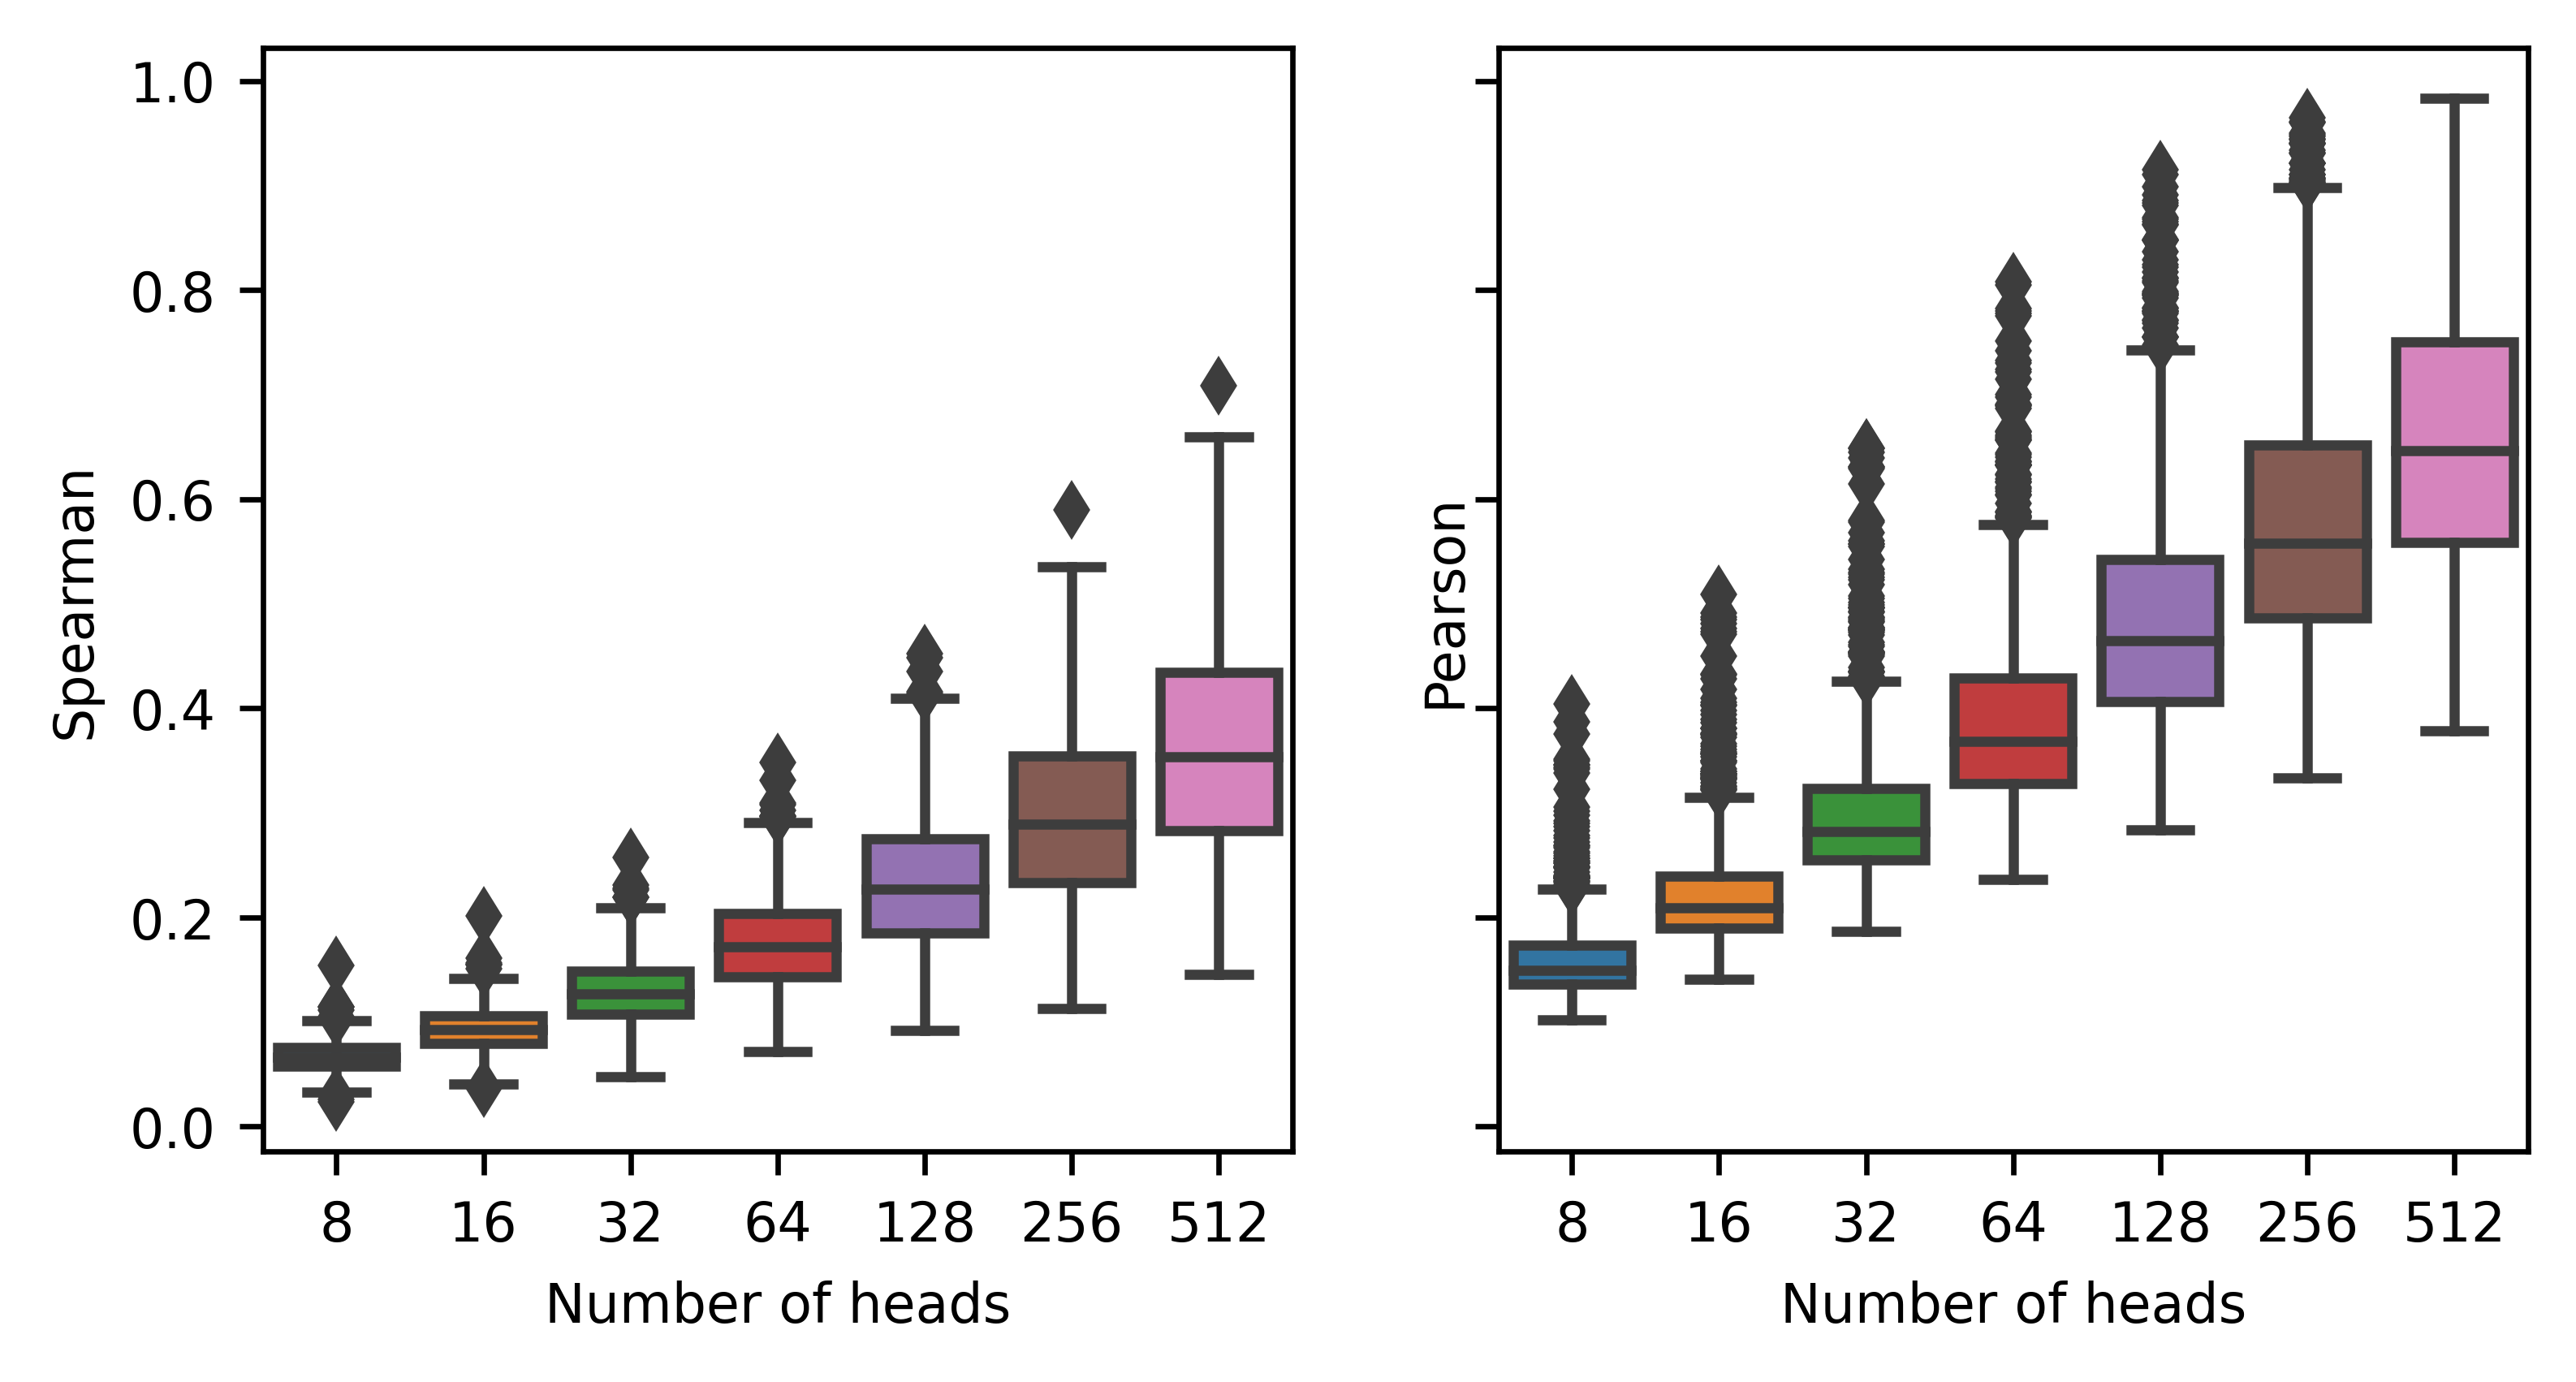

In [167]:
fig, ax = plt.subplots(nrows=1, ncols = 2, dpi=600, figsize=(6, 6/2), sharey=True, sharex=True)


cur_ax = ax[0]
sns.boxplot(x="num_attention_heads", 
               y="w_spearman", 
               data=sweep_df,
               ax = cur_ax)
cur_ax.set_xlabel('Number of heads')
cur_ax.set_ylabel(r'Spearman')

cur_ax = ax[1]
sns.boxplot(x="num_attention_heads", 
               y="w_pearson", 
               data=sweep_df,
               ax = cur_ax)
cur_ax.set_xlabel('Number of heads')
cur_ax.set_ylabel(r'Pearson')

plt.savefig('head_size_weight_correlation.pdf', dpi=600, bbox_inches="tight")

Text(0.5, 1.0, 'pearson')

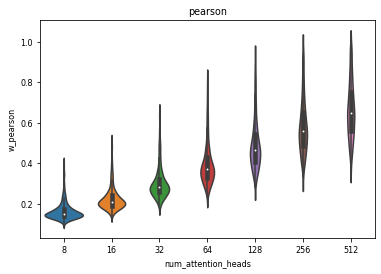

In [168]:
sns.violinplot(x="num_attention_heads", 
               y="w_pearson", 
               data=sweep_df)
plt.title('pearson')

In [169]:
plt.rcParams.update({
    "font.size": 26,
})


<Figure size 3600x1200 with 0 Axes>

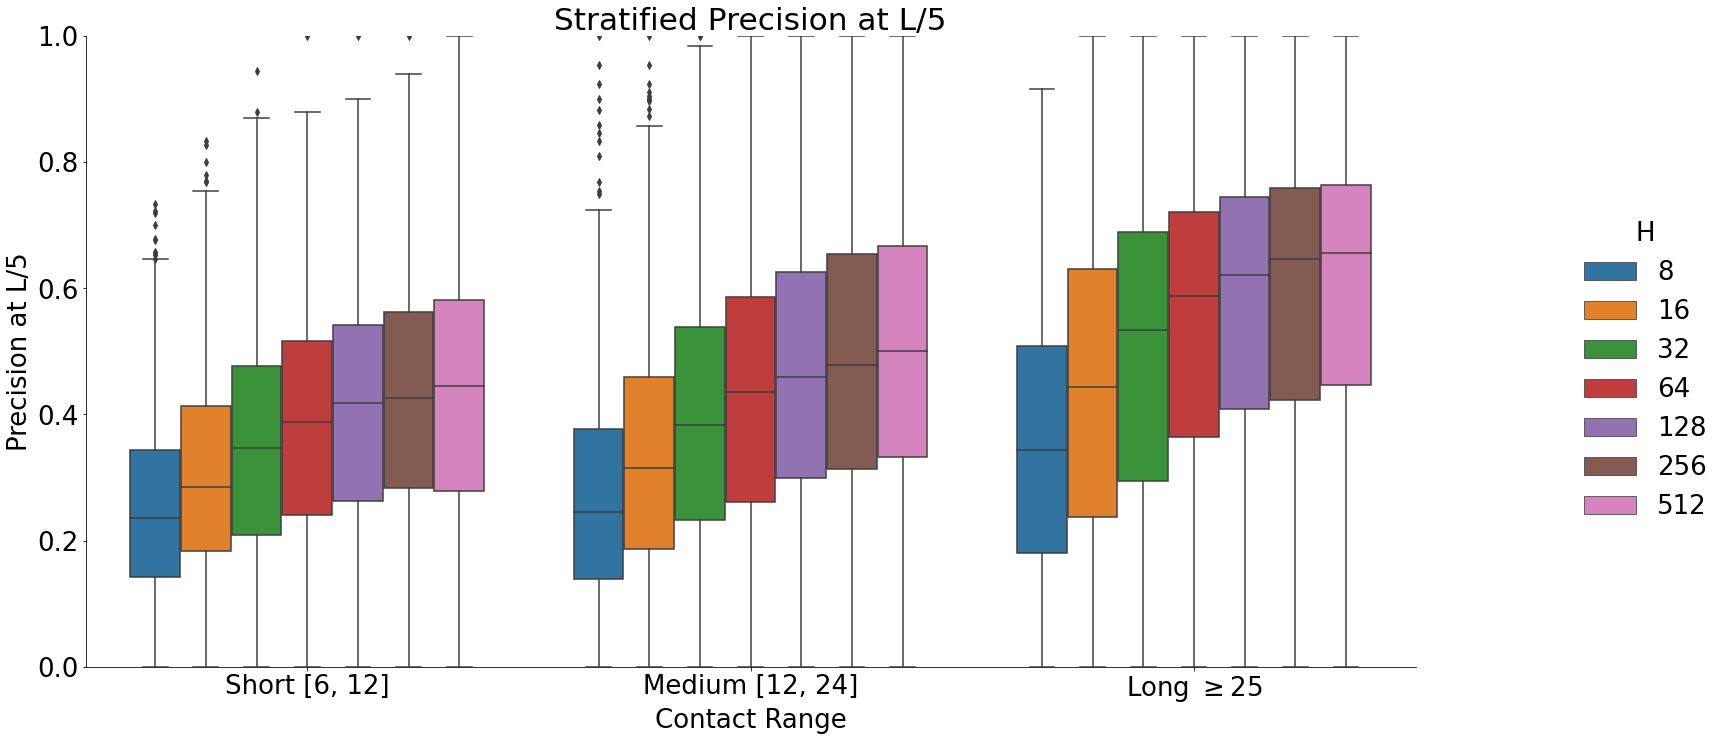

In [170]:
# fig, ax = plt.subplots(figsize=(7., 3.5), dpi=600, ncols=3, sharey=True)

plt.figure(figsize = (6, 6/3), dpi=600)
melted_df = pd.melt(sweep_df, id_vars=['num_attention_heads'], value_vars=['short_pr_at_l_5', 'medium_pr_at_l_5', 'long_pr_at_l_5'])
# plt.subplots(dpi=600)
g = sns.catplot(x="variable", 
            y="value", 
            hue="num_attention_heads",
            data=melted_df, 
            kind="box",
            height=10, 
            aspect=2)
plt.title('Stratified Precision at L/5')
g._legend.set_title('H')
g.set_xticklabels(['Short [6, 12]', 'Medium [12, 24]', r'Long $\geq 25$'])
plt.ylabel('Precision at L/5')
plt.xlabel('Contact Range')
plt.ylim([0, 1])
plt.savefig('stratified_precision_head_sweep_p_at_l_5.pdf', dpi=600, bbox_inches="tight")

<Figure size 3600x1200 with 0 Axes>

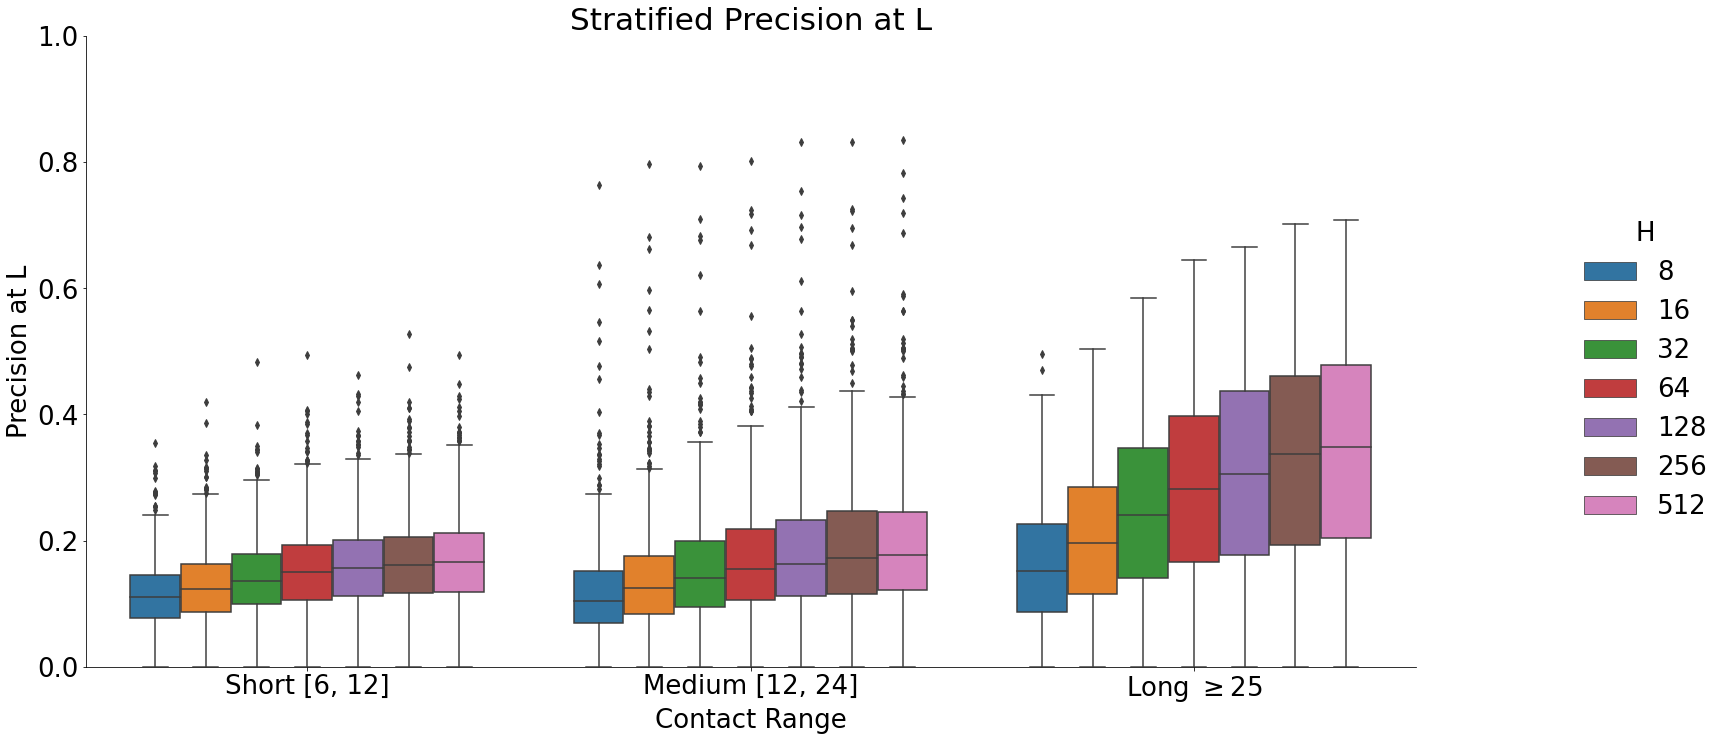

In [171]:
plt.figure(figsize = (6, 6/3), dpi=600)
melted_df = pd.melt(sweep_df, id_vars=['num_attention_heads'], value_vars=['short_pr_at_l', 'medium_pr_at_l', 'long_pr_at_l'])
# plt.subplots(dpi=600)
g = sns.catplot(x="variable", 
            y="value", 
            hue="num_attention_heads",
            data=melted_df, 
            kind="box",
            height=10, 
            aspect=2)
plt.title('Stratified Precision at L')
g._legend.set_title('H')
g.set_xticklabels(['Short [6, 12]', 'Medium [12, 24]', r'Long $\geq 25$'])
plt.ylabel('Precision at L')
plt.xlabel('Contact Range')
plt.ylim([0, 1])
plt.savefig('stratified_precision_head_sweep_p_at_l.pdf', dpi=600, bbox_inches="tight")

In [172]:
sweep_df['model'] = 'factored_attention'
import pickle as pkl
with open('num_head_sweep_stratified_metrics.pkl', 'wb') as f:
    pkl.dump(sweep_df, f)
    

In [173]:
sweep_df

,pdb,msa_length,num_seqs,attention_head_size,num_attention_heads,short_auc,short_pr_at_l,short_pr_at_l_2,short_pr_at_l_5,short_pr_at_l_10,...,medium_pr_at_l_5,medium_pr_at_l_10,w_spearman,w_pearson,long_auc,long_pr_at_l,long_pr_at_l_2,long_pr_at_l_5,long_pr_at_l_10,model
0,2w3o_1_A,100,17351,32,512,0.617357,0.430000,0.640000,0.800000,0.800000,...,0.900000,1.000000,0.418456,0.594382,0.396802,0.270000,0.400000,0.500000,0.700000,factored_attention
1,1eqz_1_B,108,4997,32,512,0.125951,0.083333,0.129630,0.190476,0.200000,...,0.285714,0.200000,0.300931,0.704268,0.143717,0.055556,0.111111,0.238095,0.400000,factored_attention
2,3no0_1_A,276,9408,32,512,0.368976,0.206522,0.318841,0.563636,0.740741,...,0.581818,0.592593,0.246827,0.521752,0.764980,0.597826,0.768116,0.927273,0.925926,factored_attention
3,1xju_1_A,156,2110,32,512,0.274740,0.173077,0.269231,0.419355,0.400000,...,0.387097,0.400000,0.418092,0.758689,0.531173,0.371795,0.589744,0.612903,0.666667,factored_attention
4,4ew5_1_B,97,2254,32,512,0.246373,0.134021,0.208333,0.368421,0.555556,...,0.421053,0.444444,0.547414,0.798406,0.210009,0.175258,0.208333,0.263158,0.222222,factored_attention
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,1zli_1_A,306,2169,32,8,0.261281,0.133987,0.222222,0.426230,0.533333,...,0.262295,0.466667,0.052415,0.128364,0.337213,0.228758,0.346405,0.459016,0.466667,factored_attention
5194,1u3j_1_B,99,1167,32,8,0.223771,0.151515,0.183673,0.315789,0.444444,...,0.263158,0.444444,0.070495,0.182705,0.364656,0.262626,0.326531,0.526316,0.666667,factored_attention
5195,3uv1_1_B,190,2175,32,8,0.125535,0.084211,0.115789,0.157895,0.263158,...,0.289474,0.315789,0.086358,0.152846,0.107655,0.078947,0.105263,0.131579,0.157895,factored_attention
5196,6alm_1_A,338,2179,32,8,0.142447,0.091716,0.147929,0.194030,0.242424,...,0.044776,0.060606,0.070647,0.137098,0.212008,0.142012,0.201183,0.298507,0.333333,factored_attention


In [174]:
sweep_df[sweep_df['num_attention_heads']==256]

,pdb,msa_length,num_seqs,attention_head_size,num_attention_heads,short_auc,short_pr_at_l,short_pr_at_l_2,short_pr_at_l_5,short_pr_at_l_10,...,medium_pr_at_l_5,medium_pr_at_l_10,w_spearman,w_pearson,long_auc,long_pr_at_l,long_pr_at_l_2,long_pr_at_l_5,long_pr_at_l_10,model
746,2w3o_1_A,100,17351,32,256,0.615651,0.410000,0.660000,0.800000,0.800000,...,0.850000,1.000000,0.345227,0.536552,0.386028,0.260000,0.360000,0.500000,0.700000,factored_attention
747,1eqz_1_B,108,4997,32,256,0.133388,0.074074,0.129630,0.142857,0.300000,...,0.142857,0.100000,0.246829,0.631779,0.131653,0.055556,0.092593,0.190476,0.400000,factored_attention
748,3no0_1_A,276,9408,32,256,0.348219,0.192029,0.275362,0.545455,0.777778,...,0.545455,0.703704,0.204308,0.454606,0.762642,0.586957,0.768116,0.909091,1.000000,factored_attention
749,1xju_1_A,156,2110,32,256,0.265667,0.173077,0.256410,0.354839,0.400000,...,0.419355,0.400000,0.329902,0.659215,0.516821,0.371795,0.525641,0.612903,0.600000,factored_attention
750,4ew5_1_B,97,2254,32,256,0.227038,0.134021,0.208333,0.368421,0.444444,...,0.421053,0.555556,0.435842,0.697372,0.211421,0.164948,0.208333,0.263158,0.222222,factored_attention
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,1k4n_1_A,183,732,32,256,0.217856,0.142077,0.186813,0.305556,0.388889,...,0.333333,0.388889,0.364110,0.721680,0.304136,0.191257,0.274725,0.472222,0.611111,factored_attention
1485,5glt_1_A,278,1033,32,256,0.318210,0.187050,0.266187,0.454545,0.666667,...,0.418182,0.518519,0.372056,0.633210,0.476827,0.294964,0.453237,0.672727,0.777778,factored_attention
1486,3uv1_1_B,190,2175,32,256,0.173490,0.110526,0.157895,0.210526,0.368421,...,0.552632,0.789474,0.392363,0.596553,0.428920,0.247368,0.389474,0.657895,0.894737,factored_attention
1487,6alm_1_A,338,2179,32,256,0.216074,0.130178,0.183432,0.298507,0.454545,...,0.134328,0.212121,0.300808,0.536104,0.507837,0.366864,0.491124,0.686567,0.666667,factored_attention
